In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import LinearSystemInput
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms.classical import ExactLSsolver
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.single_sample import HHL
from qiskit.aqua.utils import random_hermitian
from pylab import * 
import seaborn as sns

# +++++ Random Seed +++++ #
# set the random seed to get 
# the same pseudo-random matrix for every run
np.random.seed(1)

In [2]:
def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("fidelity %f" % fidelity)
    
# Fidelity is useful to check whether two states are same or not. 
# For quantum (pure) states, the fidelity is the squared overlap between them

In [3]:
params = {
     'problem': {'name': 'linear_system'},
     'algorithm': {'name': 'HHL'},
     'eigs': {'expansion_mode': 'suzuki',
              'expansion_order': 2,
              'name': 'EigsQPE',
              'num_ancillae': 3,
              'num_time_slices': 50 },
     'reciprocal': { 'name': 'Lookup'},
     'backend': { 'provider': 'qiskit.BasicAer',
                  'name': 'statevector_simulator'}
}

In [4]:
# bi = np.random.binomial(n=100, p=0.5, size=10000)
# plt.hist(bi, bins=20, normed=True);

In [5]:
''' Ridge Regression with 4 variables'''

# Parameters for distributions

N = 100
s1 = 0; s2 = 100

m_e = 0; s_e = 10


x1 = np.random.uniform(s1, s2, N)
x2 = np.random.uniform(s1, s2, N)
x3 = np.random.uniform(s1, s2, N)
x4 = np.random.uniform(s1, s2, N)


beta_1 = 1; beta_2 = 2; 
beta_3 = 2; beta_4 = 1; 

y = beta_1*x1 + beta_2*x2 + np.random.normal(m_e , s_e, N) # + beta_3*x3 + beta_4*x4 
X = pd.concat( [pd.Series(x1), pd.Series(x2), pd.Series(x3), pd.Series(x4)], axis = 1 )

XX = X.values.transpose().dot(X.values)


print( '\n Matrix correlation \n', np.corrcoef( [x1, x2, x3, x4]), '\n' )

# Condition number
k = max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1])
print( 'condition number = ', np.round( k, 2) )

'''Fitting Linear Regression using skl'''

reg = LinearRegression().fit(X, y)

print( 'R squared =', np.round( reg.score(X, y), 2 ), '\n\n' )
print( 'Coeffs (skl) = ',  reg.coef_ )


'''Fitting Linear Regression by hand'''

XX_inv = np.linalg.inv( X.values.transpose().dot(X.values) )
XY = X.values.transpose().dot(y)
print( 'Coeffs (by hand) = ', XX_inv.dot(XY) )



 Matrix correlation 
 [[ 1.         -0.0248661  -0.04298775  0.24141804]
 [-0.0248661   1.          0.07192416 -0.09257895]
 [-0.04298775  0.07192416  1.         -0.07612303]
 [ 0.24141804 -0.09257895 -0.07612303  1.        ]] 

condition number =  17.99
R squared = 0.98 


Coeffs (skl) =  [ 9.90754670e-01  2.02428480e+00  2.41289119e-02 -1.05898167e-03]
Coeffs (by hand) =  [ 0.98034802  2.01287866  0.00697224 -0.01568521]


In [6]:
# Scatter plot matrix
# sns.set(style="ticks")
# df = pd.concat( [pd.Series(x1), pd.Series(x2), pd.Series(x3), pd.Series(x4), pd.Series(y)], axis = 1 )
# sns.pairplot(df, diag_kind="kde") #, hue="species")

In [7]:
'''Quantum algorithm for linear regression (design matrix 2x2)'''

params5 = params
params5['algorithm'] = {
    'truncate_powerdim': False,
    'truncate_hermitian': False
}
params5['reciprocal'] = {
    'name': 'Lookup',
    'negative_evals': True
}
params5['eigs'] = {
    'expansion_mode': 'suzuki',
    'expansion_order': 2,
    'name': 'EigsQPE',
    'negative_evals': True,
    'num_ancillae': 6,
    'num_time_slices': 70
}
params5['initial_state'] = {
    'name': 'CUSTOM'
}
params5['iqft'] = {
    'name': 'STANDARD'
}
params5['qft'] = {
    'name': 'STANDARD'
}



matrix = XX.tolist()
vector = XY.tolist()

# Condition number
k = max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1])
print( 'condition number = ', np.round( k, 2) )


algo_input = LinearSystemInput(matrix=matrix, vector=vector)
hhl = HHL.init_params(params5, algo_input)
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend)
result = hhl.run(quantum_instance)
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

condition number =  17.99
solution  [ 1.0164 -0.e+00j  2.01956+0.e+00j -0.03228+1.e-05j -0.01496-2.e-05j]
classical solution  [ 0.98035  2.01288  0.00697 -0.01569]
probability 0.000707
fidelity 0.999527


In [14]:
# set the random seed to get the same pseudo-random matrix for every run
# np.random.seed(1)

# matrix = XX.tolist()
# vector = XY.tolist()

# # Condition number
# k = max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1])
# print( 'condition number = ', np.round( k, 2) )

[[ 9.84232574e+00 -2.15129409e+00 -4.35737670e+00 -4.92984807e+00]
 [-2.15129409e+00  1.01708146e+03  2.00931443e+03  2.00827390e+03]
 [-4.35737670e+00  2.00931443e+03  4.01712231e+03  4.00438410e+03]
 [-4.92984807e+00  2.00827390e+03  4.00438410e+03  4.01230207e+03]]
condition number =  967.28


In [8]:
''' Ill-conditioned ridge regression'''

alpha_1 = 1
alpha_2 = 3
x3 = alpha_1*x2 + alpha_2*x1 + np.random.normal(m_e , s_e, N)


gamma_1 = 1
gamma_2 = 2
x4 = gamma_1*x2 + gamma_2*x1 + np.random.normal(m_e , s_e, N)


In [9]:
# matrix = XX.tolist() ; print( 'Matrix XX \n', np.round( matrix ) )# [[2, 0], [0, 1]]
# vector = XY.astype(int).tolist() ; print( '\n Vector XY \n', np.round( vector ) ) # [1, 4]

# np.linalg.inv( matrix ).dot( vector )
# print('The Pearson coefficient between x1 and x2 is \n: ', np.round( np.corrcoef(x1, x2)[0,1], 3 ) )

X = pd.concat( [pd.Series(x1), pd.Series(x2), pd.Series(x3), pd.Series(x4)], axis = 1 )
y = beta_1*x1 + beta_2*x2 + beta_3*x3 + beta_4*x4 + np.random.normal(m_e , s_e, N)


XX = X.values.transpose().dot(X.values)


print( '\n Matrix correlation \n', np.corrcoef( [x1, x2, x3, x4]), '\n' )

# Condition number
k = max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1])
print( 'condition number = ', np.round( k, 2) )

# matrice = XX # + np.diag(np.repeat(100, 4, axis=0))
# print( np.round(XX) )

# k = max(np.linalg.svd(matrice)[1])/min(np.linalg.svd(matrice)[1])
# print( 'condition number = ', np.round( k, 2) )

'''Fitting Linear Regression using skl'''

reg = LinearRegression().fit(X, y)

print( 'R squared =', np.round( reg.score(X, y), 2 ), '\n\n' )
print( 'Coeffs (skl) = ',  reg.coef_ )


'''Fitting Linear Regression by hand'''

XX_inv = np.linalg.inv( X.values.transpose().dot(X.values) )
XY = X.values.transpose().dot(y)
print( 'Coeffs (by hand) = ', XX_inv.dot(XY) )



 Matrix correlation 
 [[ 1.         -0.0248661   0.94125811  0.864437  ]
 [-0.0248661   1.          0.29699246  0.45806107]
 [ 0.94125811  0.29699246  1.          0.96533324]
 [ 0.864437    0.45806107  0.96533324  1.        ]] 

condition number =  13848.98
R squared = 1.0 


Coeffs (skl) =  [0.98760773 2.01194804 2.02854885 0.97945853]
Coeffs (by hand) =  [0.92561992 1.97646363 2.03817769 0.98221144]


In [10]:

params5 = params
params5['algorithm'] = {
    'truncate_powerdim': False,
    'truncate_hermitian': False
}
params5['reciprocal'] = {
    'name': 'Lookup',
    'negative_evals': True
}
params5['eigs'] = {
    'expansion_mode': 'suzuki',
    'expansion_order': 2,
    'name': 'EigsQPE',
    'negative_evals': True,
    'num_ancillae': 6,
    'num_time_slices': 70
}
params5['initial_state'] = {
    'name': 'CUSTOM'
}
params5['iqft'] = {
    'name': 'STANDARD'
}
params5['qft'] = {
    'name': 'STANDARD'
}



matrix = XX.tolist()
vector = XY.tolist()

# Condition number
k = max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1])
print( 'condition number = ', np.round( k, 2) )


algo_input = LinearSystemInput(matrix=matrix, vector=vector)
hhl = HHL.init_params(params5, algo_input)
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend)
result = hhl.run(quantum_instance)
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

condition number =  13848.98
solution  [0.3021 -0.00097j 1.0482 -0.00025j 1.90355+0.00061j 1.66747-0.00042j]
classical solution  [0.92562 1.97646 2.03818 0.98221]
probability 0.000477
fidelity 0.825118


In [11]:
'''Introduction of the penalty for ill-conditioned case'''

lambda_penalty = 10**7
matrix = (XX + np.diag(np.repeat(lambda_penalty, 4, axis=0))).tolist()
print( np.round(matrix) )

k = max(np.linalg.svd(matrix)[1])/min(np.linalg.svd(matrix)[1])
print( '(new) condition number = ', np.round( k, 2) )


[[10322750.   233258.  1206202.   873707.]
 [  233258. 10335074.  1029758.   799211.]
 [ 1206202.  1029758. 14668187.  3423196.]
 [  873707.   799211.  3423196. 12544269.]]
(new) condition number =  1.77


In [12]:
algo_input = LinearSystemInput(matrix=matrix, vector=vector)
hhl = HHL.init_params(params5, algo_input)
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend)
result = hhl.run(quantum_instance)
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [0.22783+0.j 0.21717-0.j 0.90244-0.j 0.66984-0.j]
classical solution  [0.22784 0.21714 0.90245 0.66983]
probability 0.000330
fidelity 1.000000


In [65]:
print("circuit_width", result['circuit_info']['width'])
print("circuit_depth", result['circuit_info']['depth'])

circuit_width 12
circuit_depth 542321


ValueError: Argument Z must be 2-dimensional.

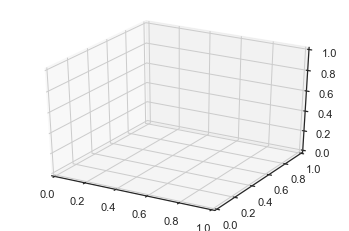

In [48]:
# 3D plot 
# from mpl_toolkits import mplot3d
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax = plt.axes(projection='3d')

# # Data for a three-dimensional line
# # zline = np.linspace(0, 15, 1000)
# # xline = np.sin(zline)
# # yline = np.cos(zline)
# #ax.plot3D(xline, yline, zline, 'gray')

# # Data for a three-dimensional line
# zline = beta_0 + beta_1*x1 + beta_2*x2
# xline = x1
# yline = x2
# # ax.plot3D(xline, yline, zline, 'gray')



# # Data for three-dimensional scattered points
# zdata = beta_0 + beta_1*x1 + beta_2*x2
# xdata = x1
# ydata = x2
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

# plt3d = plt.figure().gca(projection='3d')
# plt3d.plot_surface(zline, yline, xline)